### Interactive notebook to demo the interactive PPCA model

In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
# from scipy.stats import invgamma, lognorm
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import seaborn as sns

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

from IPython.display import display, clear_output
from ipywidgets import Output, VBox, HBox, Layout
from ipywidgets import Label, Button, FloatSlider, RadioButtons
from ipywidgets import interact

from bqplot import (
    Axis, ColorAxis, LinearScale, LogScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ppca_model import MAP, generate
from common.dataset import dataset
import common.plot.simple_plot
from common.plot.simple_plot import SimpleFigure
from common.plot.scatter import imscatter, ellipse_scatter
from common.metric.dr_metrics import DRMetric

dataset.set_data_home('./data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
X_original, X, y = dataset.load_dataset('FASHION200', preprocessing_method='standardize')

learning_rate = 0.2
n_iters = 250

# # try to remove the 'bad' class
# bad_class = 9
# mask = ~(y==bad_class)

# X_original = X_original[mask]
# X = X[mask]
# y = y[mask]

In [108]:
# run model the first time to have an init embdedding
losses, z2d_loc, z2d_scale, W, sigma = MAP(X, learning_rate, n_iters)

errors = np.linalg.norm(z2d_scale, axis=1)
avg_err, min_err, max_err  = errors.mean(), errors.min(), errors.max()
auc_rnx = DRMetric(X, z2d_loc).auc_rnx()

# global interactive data, let's call it 'state'
state = {
    'moved_points': {}, # reset moved points
    'debug_msg': 'Init state',
    'losses': losses,
    'z2d_loc': z2d_loc,
    'z2d_scale': z2d_scale,
    'errors': errors,
    'avg_err': avg_err,
    'min_err': min_err,
    'max_err': max_err,
    'auc_rnx': auc_rnx,
    'looking_id': -1, # id of point under mouse cursor
    'filter_mode': 'upper', # filter errors values
}

100%|██████████| 250/250 [00:02<00:00, 109.55it/s]


In [63]:
print(min_err, max_err)

0.104256734 0.3445318


In [64]:
def show_top_error_class():
    from collections import Counter
    errors = np.linalg.norm(state['z2d_scale'], axis=1)

    K = int(X.shape[0] * 0.1)
    labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
                  4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
                  7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

    top_K_ind = np.argpartition(errors, -K)[-K:]
    class_top_K = y[top_K_ind]
    cnt = Counter(class_top_K)
    count_top_K = []
    lbl_names = []
    for i in labels_map:
        count_top_K.append(cnt[i])
        lbl_names.append(f"{labels_map[i]} [{i}]")

    ind = list(labels_map.keys())
    plt.barh(ind, count_top_K)
    plt.yticks(ind, lbl_names)
    plt.show()

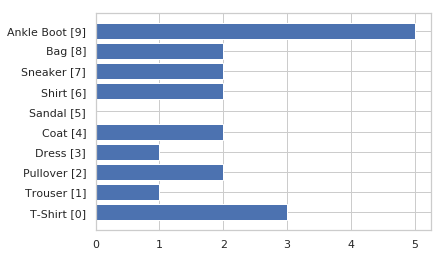

In [65]:
show_top_error_class()

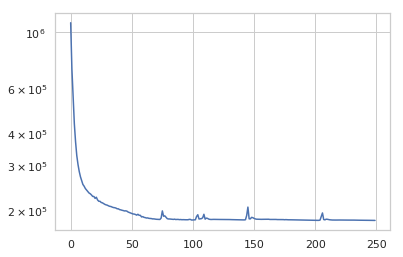

In [66]:
plt.semilogy(losses)

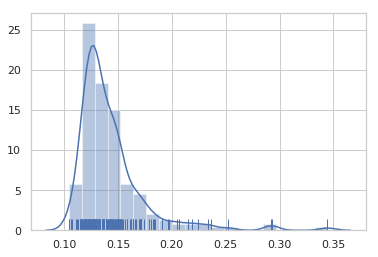

In [67]:
# plt.hist(errors, bins=20)
sns.distplot(errors, bins=20, kde=True, rug=True)

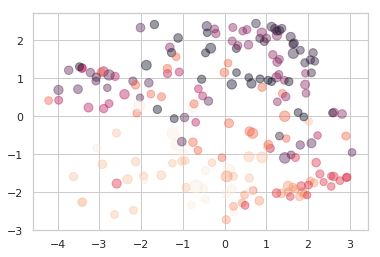

In [52]:
plt.scatter(
    x=z2d_loc[:, 0],
    y=z2d_loc[:, 1],
    c=y,
    s=500*errors,
    alpha=0.4
)

In [53]:
def scatter_with_images(ax, z2d, z2d_scale, original_data, labels_true):
    ax.scatter(z2d[:, 0], z2d[:, 1])
    imscatter(ax, z2d, data=original_data, zoom=.5, inverse_cmap=True,
              custom_cmap=None, labels_true=labels_true)
    # ellipse_scatter(ax, z2d, z2d_scale, labels_true)

In [74]:
# create base interactive scatter bqplot
sc_x = LinearScale()
sc_y = LinearScale()
sc_c = OrdinalColorScale(colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf'])
sc_size = LinearScale(min=0.0, max=0.6) # if not set, it will take range from data

def_tt = Tooltip(fields=['index', 'size'], formats=['', '.3f'])

scatt = Scatter(
    x=[], #z2d_loc[:, 0],
    y=[], #z2d_loc[:, 1],
    color=y,
    size=[], #errors,
    default_size=300, # max size of point
    # names=np.arange(z2d_loc.shape[0]),
    # display_names=False,
    default_opacities=[0.4],
    scales={'x': sc_x, 'y': sc_y, 'color': sc_c, 'size': sc_size},
    enable_move=True,
    tooltip=def_tt,
    unhovered_style={'opacity': 0.3},
    selected=[], # top_K_ind.tolist(),
    selected_style={'stroke': 'red','stroke-width':2, 'opacity':1.0},
)

def reset_scatt():
    scatt.x = []
    scatt.y = []

ax_x = Axis(scale=sc_x, grid_color='#EAECEE', grid_lines='dashed')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_color='#EAECEE', grid_lines='dashed')
ax_c = ColorAxis(scale=sc_c, orientation='vertical', side='right')

fig = Figure(marks=[scatt], axes=[ax_x, ax_y], title='',
             fig_margin=dict(top=20, bottom=20, left=20, right=20))
fig.background_style = {'fill': 'White'}
fig.layout = {'width': '600px', 'height': '530px'}

In [75]:
# debug label to show some text
lbl = Label(color='green', font_size='18px', value=state['debug_msg'])

def drag_handler(scatter, value):
    p = value['point']
    point_id = int(value['index'])
    state['moved_points'][point_id] = [float(p['x']), float(p['y'])] # TODO add sigma_fix value
    lbl.value = str(state['moved_points'])

def mouse_hover(scatter, value):
    state['looking_id'] = int(value['data']['index'])
    update_hover_image()
    
scatt.on_drag_end(drag_handler)
scatt.on_hover(mouse_hover)

In [103]:
# output widget to hold the static matplotlib plot
out = Output(layout={'border': '0px solid black', 'width': '600px', 'display': 'inline-block'})
hover_img_out = Output(layout={'border': '0px solid black', 'width': '200px', 'display': 'inline-block'})
hist_out = Output(layout={'border': '0px solid black', 'width': '600px', 'display': 'inline-block'})

# static matplotlib scatter plot with images
_, ax = plt.subplots(1, 1, figsize=(8,8))
plt.close()

_, ax_hover = plt.subplots(1, 1, figsize=(2,2))
plt.close()

_, ax_hist = plt.subplots(1, 1, figsize=(6,2))
plt.close()

In [117]:
threshold_slider = FloatSlider(min=state['min_err'], max=state['max_err'], step=0.005,
                               description='Avg variance threshold: ',
                               layout=Layout(width='500px'),
                               style={'description_width': 'initial', 'align_items':'flex-end'})

def update_threshold_slider():
    threshold_slider.min = state['min_err']
    threshold_slider.max = state['max_err']

In [118]:
# define steps to run model and update graphs in an interactive manner
# all the data are shared between interactive components via the global state

def run_ippca():
    moved_points = state['moved_points']
    sigma_fix = 1e-4
    # print('Run interactive PPCA with moved points: ', moved_points, sigma_fix)
    
    losses, z2d_loc, z2d_scale, W, sigma = MAP(
        X, learning_rate, n_iters,
        moved_points=moved_points, sigma_fix=sigma_fix)
    
    errors = np.linalg.norm(z2d_scale, axis=1)
    avg_err, min_err, max_err = errors.mean(), errors.min(), errors.max()
    aux_rnx = DRMetric(X, z2d_loc).auc_rnx()
    
    # update global state, note to change each field of the global state dict
    # state['moved_points'] = {} # reset moved points
    state['debug_msg'] = 'Init state'
    state['losses'] = losses
    state['z2d_loc'] = z2d_loc
    state['z2d_scale'] = z2d_scale
    state['errors'] = errors
    state['avg_err'] = avg_err
    state['min_err'] = min_err
    state['max_err'] = max_err
    state['auc_rnx'] = auc_rnx
    
    
def update_static_imscatter():
    with out:
        ax.clear()
        scatter_with_images(ax, state['z2d_loc'], state['z2d_scale'], X_original, y)
        ax.set_title("avg_err={:.3f}, auc_rnx={:.3f}".format(state['avg_err'], state['auc_rnx']))
        clear_output(wait=True)
        display(ax.figure)
        plt.close()
        

def update_scatter_bqplot():
    fig.title = "avg_err={:.3f}, auc_rnx={:.3f}".format(state['avg_err'], state['auc_rnx'])
    scatt.x = state['z2d_loc'][:,0]
    scatt.y = state['z2d_loc'][:,1]
    scatt.size = state['errors']
    scatt.selected = list(state['moved_points'].keys())
    
    
def update_hover_image():
    hover_id = state['looking_id']
    with hover_img_out:
        ax_hover.clear()
        ax_hover.imshow(X_original[hover_id].reshape(28,28), cmap='gray_r')
        ax_hover.axis('off')
        clear_output(wait=True)
        display(ax_hover.figure)
        plt.close()
        
        
def update_histogram():
    with hist_out:
        ax_hist.clear()
        sns.distplot(state['errors'], ax=ax_hist, bins=20, kde=True, rug=True)
        clear_output(wait=True)
        display(ax_hist.figure)
        plt.close()    

In [119]:
def show_avg_error():
    moved_ids = list(state['moved_points'].keys())
    errors = state['errors']
    avg_rest = (errors.sum() - errors[moved_ids].sum()) / (errors.shape[0] - errors[moved_ids].shape[0])
    print(f"AVG error for ALL={errors.mean()}, for REST={avg_rest}")
    

def rerun_model(btn):
    # print('before moving: '); show_avg_error(); show_top_error_class()
    run_ippca()
    # print('after moving: '); show_avg_error(); show_top_error_class()
    
    update_static_imscatter()
    update_scatter_bqplot()
    update_histogram()
    update_threshold_slider()
    

def reset_gui(_):
    reset_scatt()
    state['moved_points'] = {}
    state['debug_msg'] = 'Reset!'
    lbl.value = 'Reset!'
    
    ax.clear()
    ax_hover.clear()
    ax_hist.clear()
    out.clear_output(wait=True)
    hover_img_out.clear_output(wait=True)
    hist_out.clear_output(wait=True)
    

def on_threshold_change(change):
    fix_threshold = change['new']
    errros = state['errors']
    (ok_idx,) = (np.where(errors >= fix_threshold) if state['filter_mode'] == 'upper'
                 else np.where(errors <= fix_threshold))
    scatt.selected = ok_idx.tolist()
    lbl.value = f"{len(ok_idx)} points affected"
    
    
def on_radio_filter_change(change):
    state['filter_mode'] = change['new']
    

def set_threshold(_):
    ok_idx = scatt.selected
    if ok_idx:
        ok_points = {idx: [px, py] for idx, [px, py] in zip(ok_idx, state['z2d_loc'][ok_idx].tolist())}
        state['moved_points'] = ok_points
        lbl.value = f"{len(ok_points)} points selected"
        

# button to run iPPCA
btn_run = Button(description='Run', icon='check',  button_style='success') # 'success', 'info', 'warning', 'danger' or ''
btn_reset = Button(description='Reset', button_style='warning')
btn_set_threshold = Button(description='Set Threshold')
radio_filter_mode = RadioButtons(options=['upper', 'lower'], description='Filter:')

btn_run.on_click(rerun_model)
btn_reset.on_click(reset_gui)
btn_set_threshold.on_click(set_threshold)
threshold_slider.observe(on_threshold_change, names='value')
radio_filter_mode.observe(on_radio_filter_change, names='value')

In [121]:
# feed init data to scatter bqplot and build static imscatter
reset_gui(_)
update_scatter_bqplot()
update_static_imscatter()
update_static_imscatter()
update_histogram()

# whole layout
control_buttons = VBox([btn_set_threshold, btn_reset, btn_run], layout=Layout(margin='60px 10px 10px 10px'))
VBox([
    HBox([hist_out, hover_img_out, control_buttons]),
    HBox([VBox([threshold_slider, lbl]), radio_filter_mode]),
    HBox([out,fig]),
])

100%|██████████| 250/250 [00:02<00:00, 106.29it/s]


In [ ]:
# linear interpolate error range to bubble size
errors_as_size = np.interp(errors,
                           [np.min(errors), np.max(errors)],
                           [32, 512])

def log_interp1d(xx, yy, kind='linear'):
    '''https://stackoverflow.com/questions/29346292/logarithmic-interpolation-in-python'''
    import scipy as sp
    import scipy.interpolate
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

# interpolate errors in log scale
errors_as_size = log_interp1d(
    [np.min(errors), np.max(errors)],
    [32, 512]
)(errors)